# Demo AMFabric

### Import simulated data

In [1]:
from src.amfabric import AMFabric
from src.sdr import SDR
import json

# client stats tell us what we know about our simulated data
#
file_name = '../data/client_stats.json'
with open(file_name, 'r') as fp:
    client_state = json.load(fp)

clients = list(client_state.keys())
print('clients:', clients)

print(clients[0]) 
# Rainbow trades for all clients
#
file_name = '../data/rainbow_trades.json'
with open(file_name, 'r') as fp:
    rainbow_trades = json.load(fp)
    
rainbow_trades[1]

clients: ['DEF_Ltd', 'JKL_Ltd', 'ABC_Ltd', 'GHI_Ltd', 'MNO_Ltd', 'PQR_Ltd']
DEF_Ltd


{'trade_id': 1,
 'client': 'JKL_Ltd',
 'label': 'PURPLE',
 'r': 148,
 'g': 44,
 'b': 190}

### Library of Ploty based functions to help us to visualise the fabric

In [2]:
# library to plot data
#
import plotly.graph_objects as go

# plot trades
#
def plot_rainbow_trades(trades, state, client_filter=None):

    # lists to hold x y coordinates of each Rainbow Trade
    #
    x = []
    y = []

    # list of RGB colours for each Rainbow Trade
    #
    colours = []

    # list of labels to be displayed when mouse hovers over a Rainbow Trade
    #
    labels = []

    # size of plot for each Rainbow Trade
    #
    size = []

    # the type of marker per trade
    #
    symbol = []

    for trade_id in range(len(trades)):
        
        trade = trades[trade_id]
        client = trade['client']
        
        if client_filter is None or (isinstance(client_filter, list) and client in client_filter) or (isinstance(client_filter, str) and client_filter == client):
        
            # a coloured blob for each trade
            #
            x.append(trade_id)
            y.append(client)

            if ('anomaly_trade_id' in state[trades[trade_id]['client']] and state[trades[trade_id]['client']]['anomaly_trade_id'] == trade_id):
        
                size.append(15)

                symbol.append('diamond')

                trade_class = 'ABNORMAL'

            elif ('normal_trade_id' in state[trades[trade_id]['client']] and state[trades[trade_id]['client']]['normal_trade_id'] == trade_id):

                size.append(15)

                symbol.append('square')

                trade_class = 'NORMAL'

            else:
                size.append(10)
                symbol.append('circle')
                trade_class = ''

            # specify the hover text
            #
            labels.append('client: {} r: {} g: {} b: {} {}'.format(client, trade['r'], trade['g'], trade['b'], trade_class))

            # specify the colour for this blob
            #
            colours.append('rgb({},{},{})'.format(trade['r'], trade['g'], trade['b']))


    # the coloured points
    #
    ts_points = go.Scatter(x=x, y=y, hovertext=labels, mode='markers', marker=dict(size=size, color=colours, opacity=1.0, symbol=symbol))

    # a plot consists of a figure object
    #
    fig = go.Figure(data=[ts_points])
    fig.update_layout(width=2000, title=dict(text='Time Series'))
    fig.show()

# plot the fabric structure
#
def plot_fabric_3d(fabric, title, coords_to_highlight=None, neurons_to_plot=None, short_term_memory=1):
    x_node = []
    y_node = []
    z_node = []
    colors = []
    x_edge = []
    y_edge = []
    z_edge = []
    labels = []
    sizes = []
    pairs = set()
    nos_winners = 0
    sum_distance = 0.0
    sum_mapped = 0
    
    # 
    if neurons_to_plot is None:
        neurons_to_plot = [n for n in range(short_term_memory)]
    
    if coords_to_highlight is None:
        coords_to_highlight = list(fabric['neuro_columns'].keys())
        
    for coord_id in fabric['neuro_columns'].keys():

        if fabric['neuro_columns'][coord_id]['n_bmu'] > 0:
            nos_winners += 1
            sum_distance += fabric['neuro_columns'][coord_id]['mean_distance']
            sum_mapped += fabric['neuro_columns'][coord_id]['n_bmu']

        for neuron_id in neurons_to_plot:
            if 'trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'r', neuron_id, 'rgb', 'r') in fabric['neuro_columns'][coord_id]['neuro_column']:

                # if neuron in the top of the column and has been trained then increase size
                #
                if neuron_id == neurons_to_plot[0] and fabric['neuro_columns'][coord_id]['n_bmu'] + fabric['neuro_columns'][coord_id]['n_nn'] > 0:
                    sizes.append(20 + fabric['neuro_columns'][coord_id]['n_bmu'])
                else:
                    sizes.append(15)

                nc = fabric['neuro_columns'][coord_id]['neuro_column']

                x = fabric['neuro_columns'][coord_id]['coord'][0]
                y = fabric['neuro_columns'][coord_id]['coord'][1]
                z = max(neurons_to_plot) - neuron_id

                x_node.append(x)
                y_node.append(y)
                z_node.append(z)

                if coord_id in coords_to_highlight:
                    r = round(nc['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'r', neuron_id, 'rgb', 'r')]['numeric'])
                    g = round(nc['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'g', neuron_id, 'rgb', 'g')]['numeric'])
                    b = round(nc['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'b', neuron_id, 'rgb', 'b')]['numeric'])
                    opacity = 1.0
                else:
                    r = 255
                    g = 255
                    b = 255
                    opacity = 0.7
                colors.append('rgba({},{},{},{})'.format(r, g, b, opacity))

                labels.append('NeuroColumn: {}<br>Neuron: {}<br>n_BMU: {}<br>last_bmu: {}<br>n_nn: {}<br>last_nn: {}<br>mean_dist: {}<br>mean_sim: {}<br>r: {}<br>g:{}<br>b:{}<br>community:{}<br>community_prob:{}'.format(coord_id, 
                                                                                                                           neuron_id, 
                                                                                                                           fabric['neuro_columns'][coord_id]['n_bmu'],
                                                                                                                           fabric['neuro_columns'][coord_id]['last_bmu'],
                                                                                                                           fabric['neuro_columns'][coord_id]['n_nn'],
                                                                                                                           fabric['neuro_columns'][coord_id]['last_nn'],
                                                                                                                           fabric['neuro_columns'][coord_id]['mean_distance'] if 'mean_distance' in fabric['neuro_columns'][coord_id] else None,
                                                                                                                           fabric['neuro_columns'][coord_id]['mean_similarity'] if 'mean_similarity' in fabric['neuro_columns'][coord_id] else None,
                                                                                                                           r, g, b,
                                                                                                                           fabric['neuro_columns'][coord_id]['community_label'],
                                                                                                                           fabric['neuro_columns'][coord_id]['community_label_prob'],
                                                                                                                           ))
                
                # connect neurons in same column
                #
                if neuron_id < neurons_to_plot[-1]:
                    pair = (min((x, y, neuron_id), (x, y, neuron_id + 1)), max((x, y, neuron_id), (x, y, neuron_id + 1)))

                    pairs.add(pair)

                    x_edge.append(x)
                    x_edge.append(x)
                    x_edge.append(None)

                    y_edge.append(y)
                    y_edge.append(y)
                    y_edge.append(None)

                    nn_z = max(neurons_to_plot) - neuron_id - 1
                    z_edge.append(z)
                    z_edge.append(nn_z)
                    z_edge.append(None)

                # connect neuro_columns
                #
                for nn_id in fabric['neuro_columns'][coord_id]['nn']:
                    nn_x = fabric['neuro_columns'][nn_id]['coord'][0]
                    nn_y = fabric['neuro_columns'][nn_id]['coord'][1]

                    pair = (min((x, y, neuron_id), (nn_x, nn_y, neuron_id)), max((x, y, neuron_id), (nn_x, nn_y, neuron_id)))

                    if pair not in pairs:
                        pairs.add(pair)
                        nn_z = max(neurons_to_plot) - neuron_id
                        x_edge.append(x)
                        x_edge.append(nn_x)
                        x_edge.append(None)

                        y_edge.append(y)
                        y_edge.append(nn_y)
                        y_edge.append(None)

                        z_edge.append(z)
                        z_edge.append(nn_z)
                        z_edge.append(None)

    neuron_scatter = go.Scatter3d(x=x_node, y=y_node, z=z_node, hovertext=labels, mode='markers', marker=dict(size=sizes, color=colors, opacity=1.0))

    amf_edge_scatter = go.Scatter3d(x=x_edge, y=y_edge, z=z_edge, mode='lines', line=dict(width=0.5, color='grey'))

    if nos_winners > 0:
        mean_distance = sum_distance / nos_winners
        mean_mapped = sum_mapped / nos_winners
    else:
        mean_distance = 0.0
        mean_mapped = 0

    fig = go.Figure(data=[neuron_scatter, amf_edge_scatter])
    fig.update_layout(width=1200, height=1200, title=dict(text=title),
                      scene=dict(xaxis_title='X Coord', yaxis_title='Y Coord', zaxis_title='Sequence'))
    print('Nos Mini Columns', len(fabric['neuro_columns']), 'Now Winners:', nos_winners, 'Mean Distance:', mean_distance, 'Mean n_BMU:', mean_mapped)
    fig.show()

# plot the neurons in RGB space
#
def plot_neurons_trades(trades, fabric, title, neurons_to_plot=None, short_term_memory=1):
    raw_x = []
    raw_y = []
    raw_z = []
    raw_colour = []

    for record in trades:
        raw_x.append(record['r'])
        raw_y.append(record['g'])
        raw_z.append(record['b'])
        raw_colour.append('rgb({},{},{})'.format(record['r'], record['g'], record['b']))
    
    raw_scatter = go.Scatter3d(x=raw_x, y=raw_y, z=raw_z, mode='markers+text', marker=dict(size=3, color=raw_colour, opacity=1.0, symbol='square'))

    neuron_x = []
    neuron_y = []
    neuron_z = []
    neuron_colour = []
    neuron_label = []
    neuron_size = []
    hover_text = []

    if neurons_to_plot is None:
        neurons_to_plot = [s for s in range(short_term_memory)]
    
    for coord in fabric['neuro_columns']:
        for neuron_id in neurons_to_plot:
            # plot the neuron if it exists
            if 'trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'r', neuron_id, 'rgb', 'r') in fabric['neuro_columns'][coord]['neuro_column']:
                if fabric['neuro_columns'][coord]['n_bmu'] + fabric['neuro_columns'][coord]['n_nn'] > 0 and neuron_id == neurons_to_plot[-1]:

                    neuron_label.append(str(coord))
                    if fabric['neuro_columns'][coord]['n_bmu'] > 0:
                        neuron_size.append(fabric['neuro_columns'][coord]['n_bmu'] + 20)
                    else:
                        neuron_size.append(fabric['neuro_columns'][coord]['n_nn'] + 15)

                else:
                    neuron_label.append(None)
                    neuron_size.append(15)

                neuron_x.append(fabric['neuro_columns'][coord]['neuro_column']['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'r', neuron_id, 'rgb', 'r')]['numeric'])
                neuron_y.append(fabric['neuro_columns'][coord]['neuro_column']['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'g', neuron_id, 'rgb', 'g')]['numeric'])
                neuron_z.append(fabric['neuro_columns'][coord]['neuro_column']['trade:*:{}:{}:{}:{}:{}'.format('has_rgb', 'b', neuron_id, 'rgb', 'b')]['numeric'])
                neuron_colour.append('rgb({},{},{})'.format(round(neuron_x[-1]), round(neuron_y[-1]), round(neuron_z[-1])))

                hover_text.append('NeuroColumn: {}<br>Neuron: {}<br>n_BMU: {}<br>last_bmu: {}<br>n_nn: {}<br>last_nn: {}<br>mean_dist: {}<br>mean_sim: {}<br>r: {}<br>g:{}<br>b:{}<br>'.format(coord, 
                                                                                                                               neuron_id, 
                                                                                                                               fabric['neuro_columns'][coord]['n_bmu'],
                                                                                                                               fabric['neuro_columns'][coord]['last_bmu'],
                                                                                                                               fabric['neuro_columns'][coord]['n_nn'],
                                                                                                                               fabric['neuro_columns'][coord]['last_nn'],
                                                                                                                               fabric['neuro_columns'][coord]['mean_distance'] if 'mean_distance' in fabric['neuro_columns'][coord] else None,
                                                                                                                               fabric['neuro_columns'][coord]['mean_similarity'] if 'mean_similarity' in fabric['neuro_columns'][coord] else None,
                                                                                                                               
                                                                                                                               neuron_x[-1], neuron_y[-1], neuron_z[-1]))
            
    neuron_scatter = go.Scatter3d(x=neuron_x, y=neuron_y, z=neuron_z, hovertext=hover_text, text=neuron_label, mode='markers+text', marker=dict(size=neuron_size, color=neuron_colour, opacity=0.7))

    fig = go.Figure(data=[raw_scatter, neuron_scatter])
    fig.update_layout(scene=dict(xaxis_title='RED', yaxis_title='GREEN', zaxis_title='BLUE'),
                      width=1200, height=1200,
                      title=dict(text=title))
    fig.show()

# plot matrix profile
#
def plot_matrix_profile(amf, por_results, std_factor = 1):
    sp_mp = []
    sp_anomaly = []
    sp_motif = []
    sp_anomaly_threshold = []
    sp_motif_threshold = []
    sp_mean = []
    sp_std_upper = []
    sp_std_lower = []

    

    sp_anomalies = amf.get_anomalies()
    sp_motifs = amf.get_motifs()

    for por in por_results:
        sp_mp.append(por['bmu_distance'])

        sp_mean.append(por['mean_distance'])
        sp_std_upper.append(por['mean_distance'] + (std_factor * por['std_distance']))
        sp_std_lower.append(max(por['mean_distance'] - (std_factor * por['std_distance']), 0.0) )


        sp_anomaly_threshold.append(por['anomaly_threshold'])
        sp_motif_threshold.append(por['motif_threshold'])

        if por['ref_id'] in sp_anomalies:
            sp_anomaly.append(por['bmu_distance'])
        else:
            sp_anomaly.append(None)
        if por['ref_id'] in sp_motifs:
            sp_motif.append(por['bmu_distance'])
        else:
            sp_motif.append(None)

    
    sp_mp_scatter = go.Scatter(name='Matrix Profile', x=[idx for idx in range(len(sp_mp))], y=sp_mp, mode='lines', line=dict(width=2.0, color='green'))
    
    sp_anomaly_scatter = go.Scatter(name='anomalies', x=[idx for idx in range(len(sp_anomaly))], y=sp_anomaly, mode='markers+text', marker=dict(size=10, color='red', opacity=0.7))
    sp_motif_scatter = go.Scatter(name='motifs', x=[idx for idx in range(len(sp_motif))], y=sp_motif, mode='markers+text', marker=dict(size=10, color='green', opacity=0.7))

    sp_motif_threshold_scatter = go.Scatter(name='motif threshold', x=[idx for idx in range(len(sp_motif_threshold))], y=sp_motif_threshold, mode='lines', line=dict(width=1.0, color='blue'))
    sp_anomaly_threshold_scatter = go.Scatter(name='anomaly threshold', x=[idx for idx in range(len(sp_anomaly_threshold))], y=sp_anomaly_threshold, mode='lines', line=dict(width=1.0, color='red'))

    sp_mean_scatter = go.Scatter(name='mean', x=[idx for idx in range(len(sp_mean))], y=sp_mean, mode='lines', line=dict(width=2.0, color='black'))
    sp_std_upper_scatter = go.Scatter(name='stdev', x=[idx for idx in range(len(sp_std_upper))], y=sp_std_upper, mode='lines', line=dict(width=2.0, color='yellow'))
    sp_std_lower_scatter = go.Scatter(name='stdev', x=[idx for idx in range(len(sp_std_lower))], y=sp_std_lower, mode='lines', line=dict(width=2.0, color='yellow'))
    
    fig = go.Figure(data=[sp_mp_scatter, sp_anomaly_scatter, sp_motif_scatter, sp_motif_threshold_scatter, sp_anomaly_threshold_scatter, sp_mean_scatter, sp_std_upper_scatter, sp_std_lower_scatter,])
    fig.update_layout(scene=dict(xaxis_title='REF ID', yaxis_title='Similarity'), width=1400, height=900,
                      title=dict(text='AMFabric Pooler Anomalies & Motifs'))
    fig.show()

### Prepare the SDRs

In [3]:
# prepare a dictionary keyed by client with the sdrs for each trade
#
training_sdrs = {}

for record in rainbow_trades:
    
    if record['client'] not in training_sdrs:
        training_sdrs[record['client']] = {'sdrs':[], 'trades': []}
    
    sdr = SDR()
    
    # add generalise edge to the trade id - this edge will not be 'hebbian learnt' but will be simply tagged to the Neurocolumn neuron
    #
    sdr.set_item(source_node=('trade', '*'),
                 edge=('generalise', None),
                 target_node=('trade', str(record['trade_id'])),
                 probability=1.0
                 )
    
    # add has_label edge to serve as a classification - this will be hebbian learnt
    #
    sdr.set_item(source_node=('trade', '*'),
                 edge=('has_label', None),
                 target_node=('Colour', str(record['label'])),
                 probability=1.0
                 )
    
    # add the numeric egdes representing red, green, blue mixture - these will be hebbian learnt
    for field in ['r', 'g', 'b']:
        sdr.set_item(source_node=('trade', '*'),
                     edge=('has_rgb', field),
                     target_node=('rgb', field),
                     probability=1.0,
                     numeric=record[field],
                     numeric_min=0,
                     numeric_max=255
                     )

    training_sdrs[record['client']]['sdrs'].append((record['trade_id'], sdr))
    training_sdrs[record['client']]['trades'].append(record)
    

clients = list(training_sdrs.keys())
client = clients[0]
print(client)
training_sdrs[client]['sdrs'][0][1].sdr

DEF_Ltd


{'trade:*:generalise:None:trade:0': {'source_type': 'trade',
  'source_uid': '*',
  'target_type': 'trade',
  'target_uid': '0',
  'edge_type': 'generalise',
  'edge_uid': None,
  'prob': 1.0,
  'numeric': None,
  'numeric_min': None,
  'numeric_max': None},
 'trade:*:has_label:None:Colour:RED': {'source_type': 'trade',
  'source_uid': '*',
  'target_type': 'Colour',
  'target_uid': 'RED',
  'edge_type': 'has_label',
  'edge_uid': None,
  'prob': 1.0,
  'numeric': None,
  'numeric_min': None,
  'numeric_max': None},
 'trade:*:has_rgb:r:rgb:r': {'source_type': 'trade',
  'source_uid': '*',
  'target_type': 'rgb',
  'target_uid': 'r',
  'edge_type': 'has_rgb',
  'edge_uid': 'r',
  'prob': 1.0,
  'numeric': 245,
  'numeric_min': 0,
  'numeric_max': 255},
 'trade:*:has_rgb:g:rgb:g': {'source_type': 'trade',
  'source_uid': '*',
  'target_type': 'rgb',
  'target_uid': 'g',
  'edge_type': 'has_rgb',
  'edge_uid': 'g',
  'prob': 1.0,
  'numeric': 41,
  'numeric_min': 0,
  'numeric_max': 255},

### Select a client and instantiate an area of the fabric to train

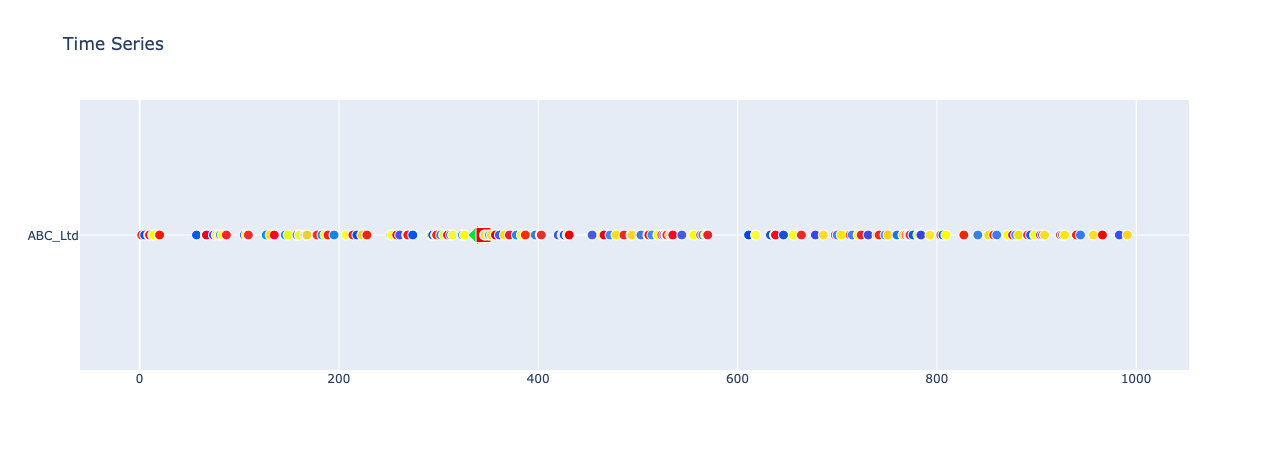

{'nos_sequences': 59,
 'nos_trades': 172,
 'seq_idx': 0,
 'state': 'normal',
 'pattern': True,
 'anomaly_seq': 2,
 'normal_dist': ['RED', 'BLUE', 'YELLOW'],
 'anomaly_dist': ['GREEN'],
 'noise': 0.2,
 'anomaly_trade_id': 339,
 'anomaly_trade_offset': 60,
 'normal_trade_id': 345,
 'normal_trade_offset': 61}

In [4]:
selected_client = 'ABC_Ltd'

# plot the clients trades
#
plot_rainbow_trades(rainbow_trades, client_state, selected_client)

# and plot the client's stats
#
client_state[selected_client]

### Train the fabric

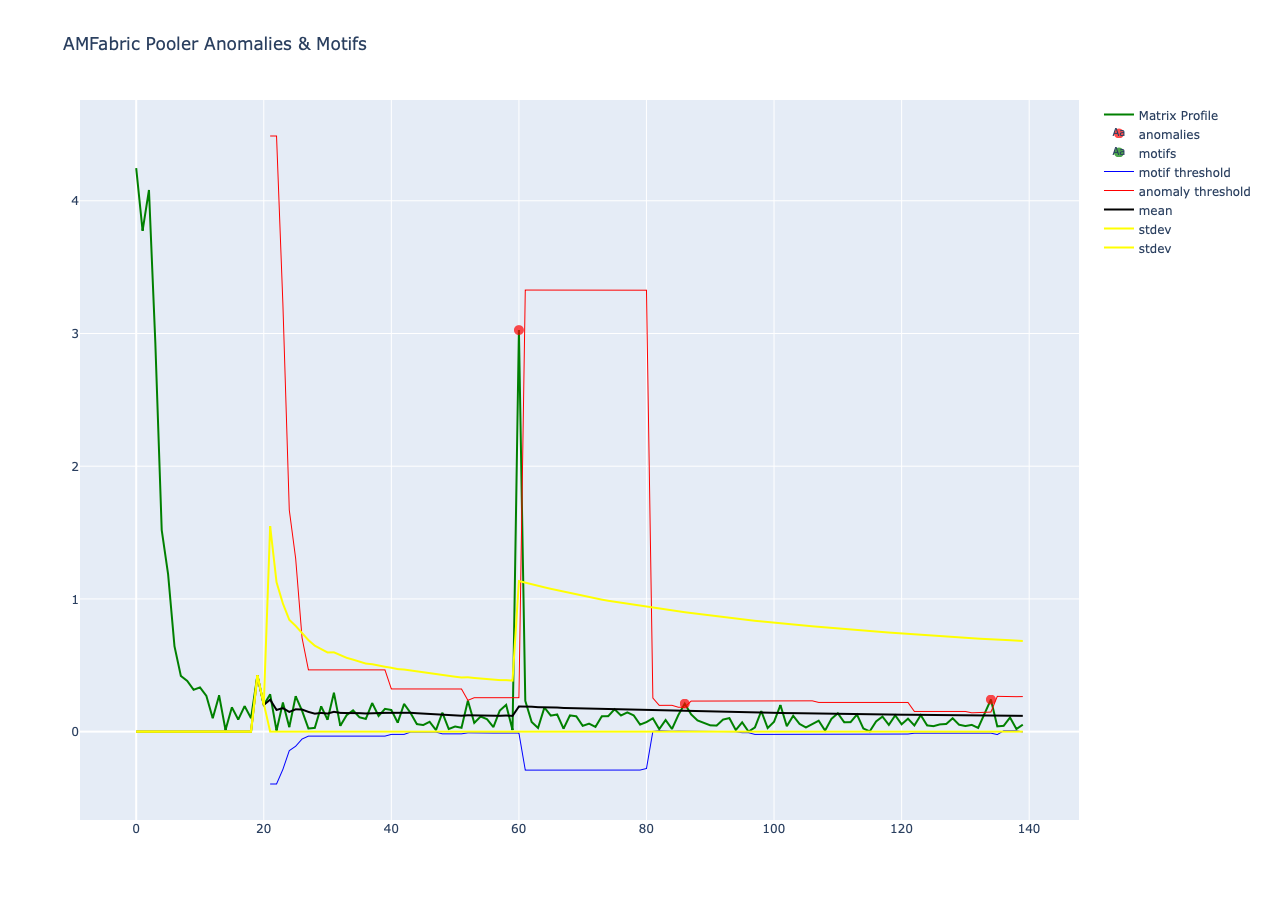

In [5]:
# the length of sequence to hold in short term memory
#
short_term_memory = 1

# feed in trades from start to end
#
start_id = 0
nos_trades = 140

# lookback window threshold for detecting anomalies and motifs
#
mp_threshold = 0.20

# connection topology of neur_column in amfabric
#
structure = 'star'

# edges with probabilities below this threshold will be assumed zero and deleted
#
prune_threshold = 0.001

# a random seed used when growing the fabric and initialising neuro columns
#
random_seed = 221166

# instantiate an area of the amfabric for the selected client and call it '<client>_rainbow_trades'
#
amf = AMFabric(uid='{}_rainbow_trades'.format(selected_client),
               short_term_memory=short_term_memory,
               mp_threshold=mp_threshold,
               structure=structure,
               prune_threshold=prune_threshold,
               random_seed=random_seed)

# a list to collect the path of reasoning data
#
por_results = []


for rec_id in range(start_id, min(start_id + nos_trades, len(training_sdrs[selected_client]['sdrs']))):
    
    trade_id = training_sdrs[selected_client]['sdrs'][rec_id][0]
    #print('processing trade:', trade_id)
    
    sdr = training_sdrs[selected_client]['sdrs'][rec_id][1]
    
    # tell the training method to not 'learn' edges of type generalise
    #
    por = amf.train(sdr=sdr, ref_id=trade_id, non_hebbian_edges=('generalise', ), fast_search=False, similarity_learn=True)
    
    por_results.append(por)

if nos_trades > 50:
    plot_matrix_profile(amf, por_results, std_factor=2)

### Current Fabric State

Nos Mini Columns 84 Now Winners: 48 Mean Distance: 0.47691933514757867 Mean n_BMU: 2.9166666666666665


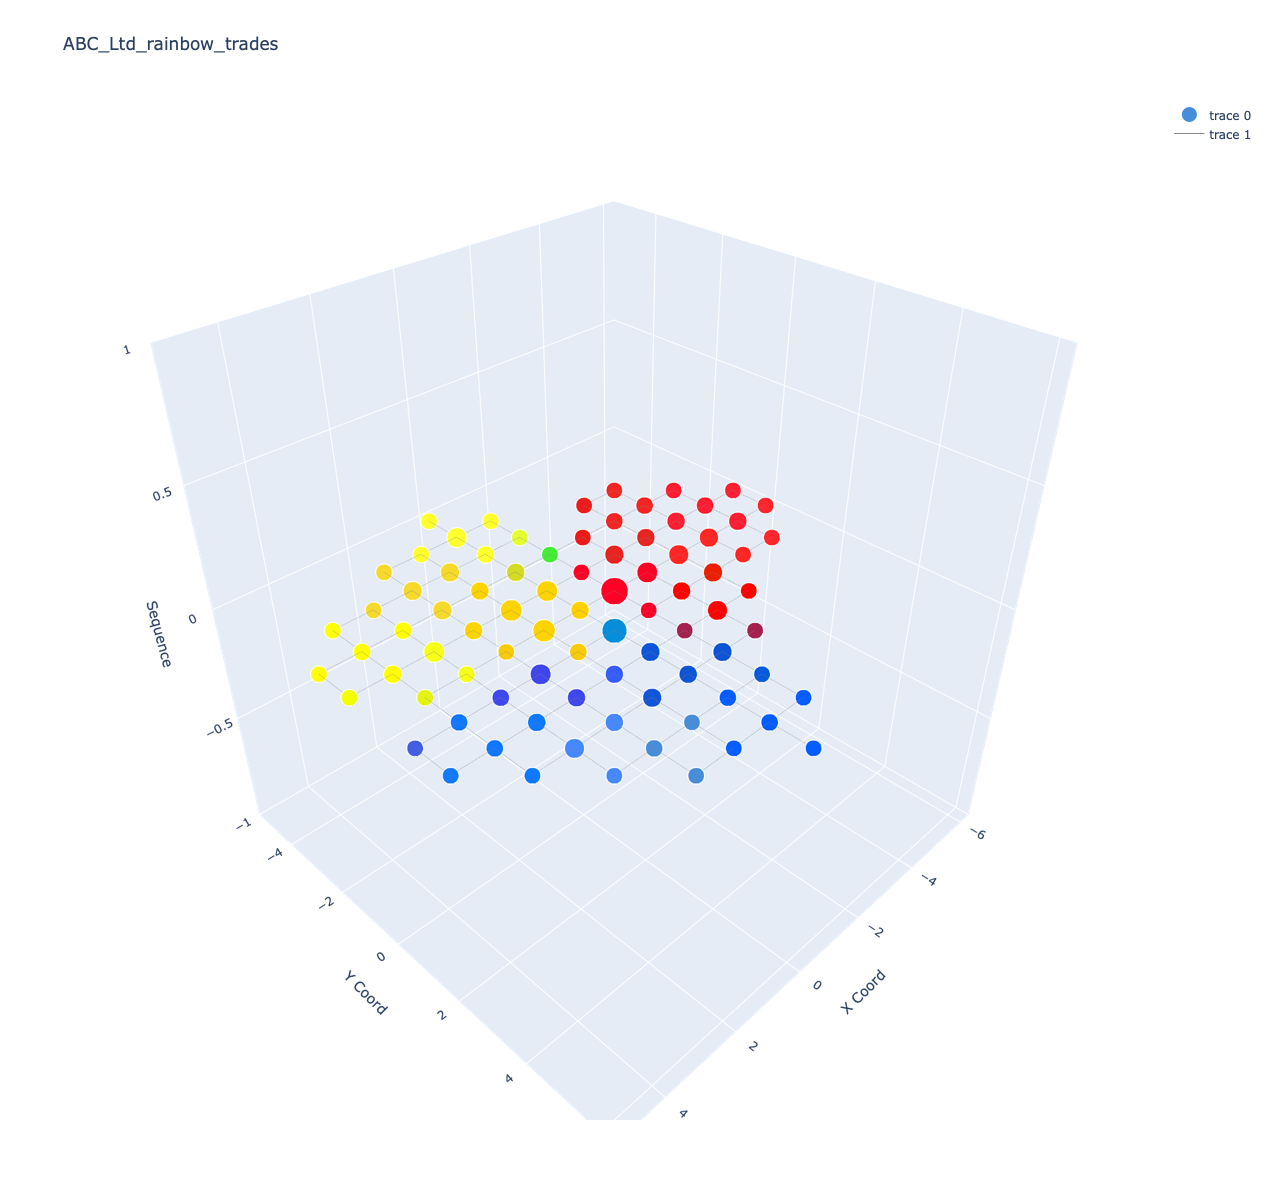

In [6]:
# extract the current fabric
#
fabric = amf.decode_fabric()

# print specific level
#
plot_fabric_3d(fabric, '{}_rainbow_trades'.format(selected_client), coords_to_highlight=None, neurons_to_plot=[0], short_term_memory=short_term_memory)


#plot_fabric_3d(fabric, '{}_rainbow_trades'.format(selected_client), coords_to_highlight=None, neurons_to_plot=[i for i in range(short_term_memory)], short_term_memory=short_term_memory)

# or highlight a neuro_column
#
#plot_fabric_3d(fabric, '{}_rainbow_trades'.format(selected_client), coords_to_highlight=['-1:0'], neurons_to_plot=None, short_term_memory=short_term_memory)

### Path of Reasoning

In [7]:
# print out POR of last trade
#
por_idx = -1
for attr in por_results[por_idx]:
    if attr not in ['fabric_distance']:
        print(attr, por_results[por_idx][attr])

# print out POR for Search calc for BMU NeuroColumn 
print('')
print('dist for BMU coord:', por_results[por_idx]['bmu'])
por_results[por_idx]['fabric_distance'][por_results[por_idx]['bmu']]

ref_id 773
anomaly_threshold 0.2641022708300642
motif_threshold -0.002724159406274934
bmu -5:-1
bmu_distance 0.052372509080269566
bmu_similarity 0.9934534363649663
anomaly False
motif False
updated_bmu -5:-1
updated_bmu_learn_rate 0.9934534363649663
updated_nn ['-5:-2', '-5:0', '-4:-1', '-6:-1']
updated_nn_learn_rate [0.9805672706902923, 0.9882646056549127, 0.9881879670124526, 0.9934534363649663]
coords_grown ['-6:-1']
mean_distance 0.11889321908094237
std_distance 0.2820209379140183

dist for BMU coord: -5:-1


{'distance': 0.052372509080269566,
 'similarity': 0.9934534363649663,
 'last_bmu': 0,
 'por': {0: {'distance': 0.052372509080269566,
   'edges': {'trade:*:has_rgb:r:0:rgb:r': {'prob': {'distance': 9.850214088835685e-09,
      'nc': 0.9999999901497859,
      'compare_nc': 1.0},
     'numeric': {'distance': 0.0008802530857553448,
      'nc': 0.9991197469142447,
      'compare_nc': 1.0},
     'distance': 0.0008802629359694336},
    'trade:*:has_rgb:g:0:rgb:g': {'prob': {'distance': 1.517498238179371e-08,
      'nc': 0.9999999848250176,
      'compare_nc': 1.0},
     'numeric': {'distance': 0.03152460910054146,
      'nc': 0.1452500992966199,
      'compare_nc': 0.11372549019607843},
     'distance': 0.03152462427552384},
    'trade:*:has_label:None:0:Colour:RED': {'prob': {'distance': 3.230457013003729e-10,
      'nc': 0.9999999996769543,
      'compare_nc': 1.0},
     'numeric': {'distance': 0.0, 'nc': 1.0, 'compare_nc': 1.0},
     'distance': 3.230457013003729e-10},
    'trade:*:has_rgb

### Plot Neurons Versus Trades

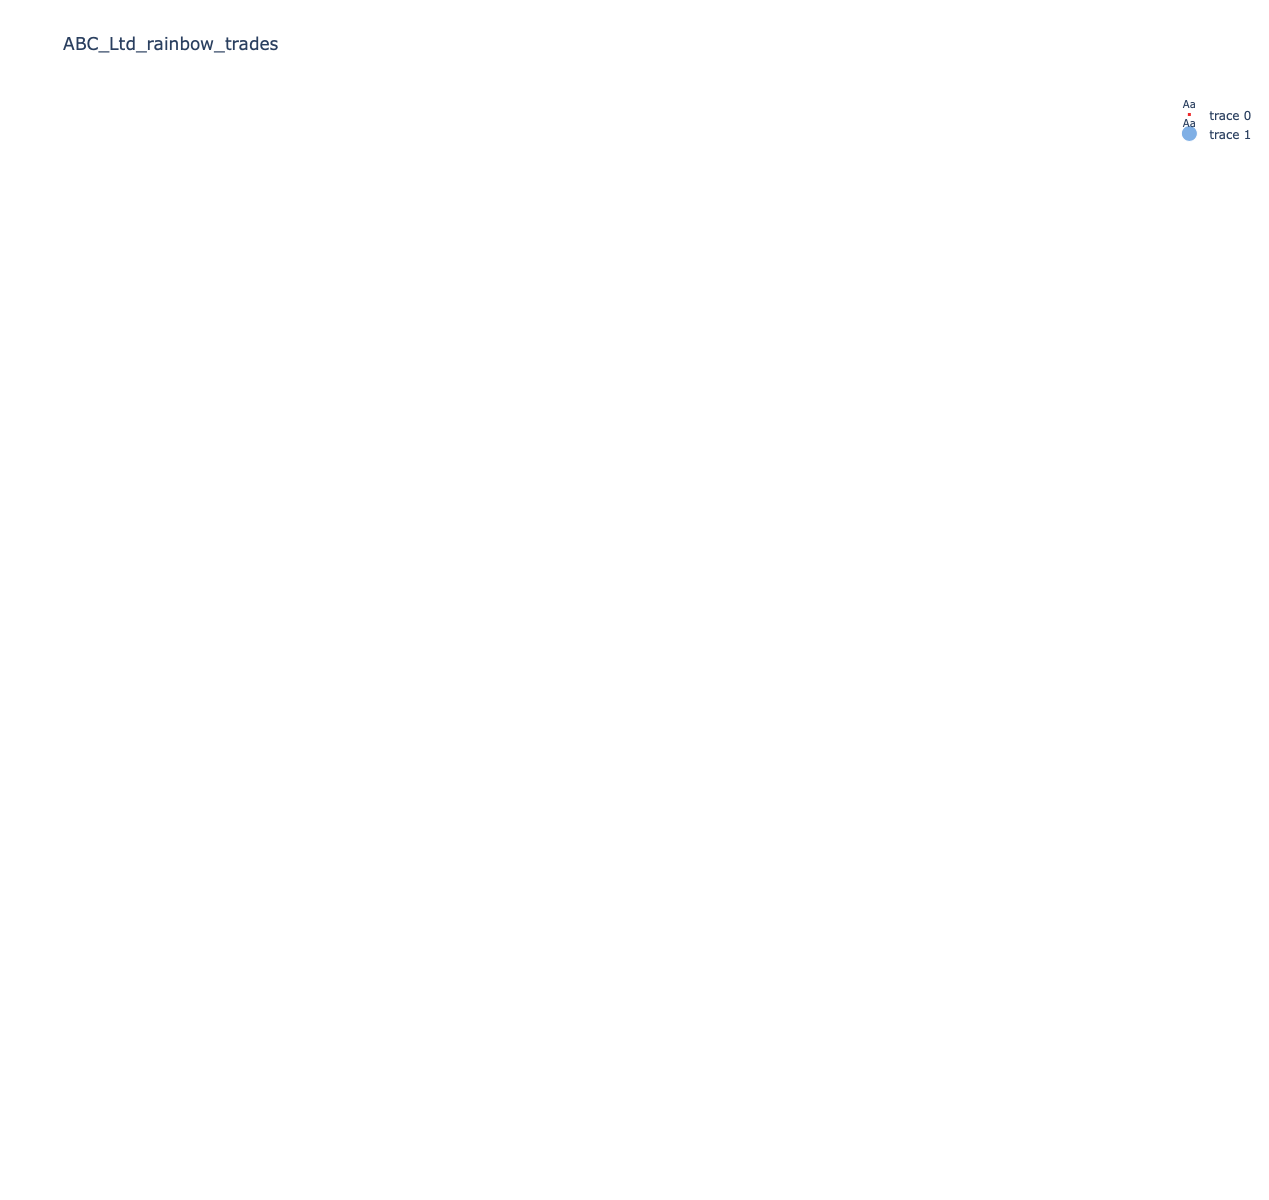

In [8]:
# print Neurons within RGB space
#
plot_neurons_trades(training_sdrs[selected_client]['trades'][0: start_id + nos_trades], fabric, '{}_rainbow_trades'.format(selected_client), neurons_to_plot=[i for i in range(short_term_memory)], short_term_memory=short_term_memory)

### Predicting trades given a context

In [9]:
import random

# randomly choose a starting trade in the sequence for this client
#
start_idx = random.randint(0, len(training_sdrs[selected_client]['trades']) - short_term_memory)
print('starting trade index', start_idx)


# build up context sdrs for query
#
context_sdrs = []
for idx in range(start_idx, start_idx + short_term_memory):

    record = training_sdrs[selected_client]['trades'][idx]
    
    # create an sdr and add to the context list of sdrs
    #
    if len(context_sdrs) < short_term_memory - 1:
        
        sdr = SDR()
        sdr.set_item(source_node=('trade', '*'),
                     edge=('has_label', None),
                     target_node=('Colour', str(record['label'])),
                     probability=1.0
                     )

        for field in ['r', 'g', 'b']:
            sdr.set_item(source_node=('trade', '*'),
                         edge=('has_rgb', field),
                         target_node=('rgb', field),
                         probability=1.0,
                         numeric=record[field],
                         numeric_min=0,
                         numeric_max=255
                         )
        context_sdrs.append(sdr)
        print('context trade', record)
        
    else:
        print('')
        print('trade to predict', record)

print('')

# query the Associative Memory fabric with the context
#
result_1 = amf.query(sdr=context_sdrs, fast_search=True)

print(result_1['coords'])


# the result is the nearest NeuroColumn so extract out the learnt edges
#
sdr_result_1 = [(result_1['neuro_column'][key]['edge_type'],
               result_1['neuro_column'][key]['target_type'], 
               result_1['neuro_column'][key]['target_uid'],
               result_1['neuro_column'][key]['neuron_id'],
               result_1['neuro_column'][key]['prob'], 
               result_1['neuro_column'][key]['numeric'] if 'numeric' in result_1['neuro_column'][key] else None)
              for key in result_1['neuro_column'] 
              if result_1['neuro_column'][key]['edge_type'] != 'generalise']

# sort by neuron id, edge_type, target_type and descending 'probability'
#
sdr_result_1.sort(key=lambda x: (x[3], x[0], x[1], -x[4]))
sdr_result_1

starting trade index 103

trade to predict {'trade_id': 535, 'client': 'ABC_Ltd', 'label': 'RED', 'r': 255, 'g': 0, 'b': 38}

['4:-3']


[('has_label', 'Colour', 'YELLOW', 0, 0.9990760167433428, None),
 ('has_rgb', 'rgb', 'b', 0, 0.9995118723303992, 0.3102393311690117),
 ('has_rgb', 'rgb', 'g', 0, 0.9985892934009266, 254.96850000526848),
 ('has_rgb', 'rgb', 'r', 0, 0.9934449632892479, 254.2096457769308)]